In [1]:
#change the folder to your default installation folder
folder = '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc/'

from pyetc import *
import os
import matplotlib.pyplot as plt
from astropy import constants



#this is a package of mine for plot quality, comment it and the following row in case you use this notebook 
from setplot import set_plot_style
set_plot_style()

# LOGGING

- When you create an object of the WST class (which inherits methods of the ECT one) the _ _init_ _ from WST is used

        def __init__(self, log=logging.INFO, skip_dataload=False):
            self.refdir = CURDIR` #set the directory to the one where the data are stored
            self.version = __version__` #version from version.py
            setup_logging(__name__, level=log, stream=sys.stdout) # #
            self.logger = logging.getLogger(__name__) #all the info is saved here
            self.logger.propagate = False #not passing the log to higher levels
            
this overwrites the constructor of ETC, you can set the logging status, the main logging status which have sense is **INFO** since it stores all the relevant information from the WST, we can also use **DEBUG** which still prints the **INFO** + other `self.logger.debug` used in the main ETC code

    # # function from the **Muse Python Data Analysis Framework**: it sets a name for the logger which is the name of the module (WST), then the level (INFO) in this case, the stream is the terminal, or console


---
- #### Now we create a default object:
we can change the logging level, in case of higher level (`WARNING`, `ERROR`, `CRITICAL`), all the prints of lower levels (in this case the _info_, available trough the `get_info` method, wont be available

There is another parameter `skip_dataload` that can be set to `True` if not the default is to not skip the load and it calls for every pair of instrument and channel the `get_data` function taking data also from the `CURDIR` directory, in particular it adds the following parameters:
- 'wave': `ins['wave'] = WaveCoord(cdelt=ins['dlbda'], crval=ins['lbda1'], cunit=u.angstrom)` from `mpdaf`, is basically a dictionary in a WCS Keywords format, it has specifically:
             Number of WCS axes: 1 since it's only wavelength
             CTYPE : 'LINEAR'
             CRVAL : 6000.0  value of the reference pixel
             CRPIX : 1.0  reference pixel
             PC1_1  : 1.0  rotation (1 means it's horizontal)
             CDELT : 0.97  scaling (in this example 1 pixel is 0.97 Angstrom)
             NAXIS : 0  0, 
             ###############
             this last should be set to 0 and number of pixels for the wavelength 
             but I'm not completely sure, probably not important
             ###############
This object does not have specifically an end, but could have in principle only the initial wavelength and the step, the end is defined by the size of the flux/trans/emi used in the `mpdaf.Spectrum` object


- 'sky' 
- 'instrans'
- 'skys'
- 'chan'
- 'name': takes this directly as a parameter, e.g. `get_data(self.ifs, chan, 'ifs', CURDIR) `
- ...

    The other are reported here: https://pyetc-wst.readthedocs.io/en/latest/tutorial.html

In [2]:
obj_WST = WST(log = 'DEBUG', skip_dataload = False)

here you see the print to console of the `INFO` logging if you are logged in the right way

This is available through the `info` method of WST class which relies on the _  _info_ from ETC class:

    def _info(self, ins_names, full=False)

where `ins_names` are **['ifs', 'moslr', 'moshr']** 

The full is to print also the information regarding the `sky` and `moon`


In [3]:
#obj_WST.info(full = True)

## INSTRUMENT DATA STRUCTURE

There are:
- the 2 channels for the IFS
- the 3 for the MOS LR
- the 4 for the MOS HR
---
Going on with the data structure of the WST object, let's look at the `get_data` we were looking before, let's see what's in the files that are loaded as `tab = Table.read(fname, unit_parse_strict="silent")`


you can do it directly below:

In [4]:
#check with ESO skycalc to not use local database ! ! ! 

fname = '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc/data/WST/ifs_red_brightsky_1.2.fits'
tab = Table.read(fname, unit_parse_strict="silent") 

#"silent" means that if a unit string cannot be parsed, 
#Astropy will just ignore it without raising an error or warning.

display(tab[:5])

lam,flux,dflux1,dflux2,trans,dtrans1,dtrans2,flux_sml,flux_ssl,flux_zl,flux_tie,flux_tme,flux_ael,flux_arc,trans_ma,trans_o3,trans_rs,trans_ms
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
600.0,3784.0077862345156,38.34151115929752,38.34151115929752,0.6007221026594367,0.0,0.0,3656.065574719791,4.274895185156112,34.910028026354425,0.0,0.0,1.2819412515795536e-13,88.75728830321167,0.6870081677453106,0.6591075371258439,0.6477208770133244,0.6666835514226435
600.097,5104.910375943149,51.77719934682653,51.77719934682653,0.8112142473378763,0.0,0.0,4932.180784617351,5.7732758563225355,47.10221546776422,0.0,0.0,0.0013263295993318673,119.85277367211081,0.9277184686436073,0.890149494538644,0.8748005775639618,0.9003938717852492
600.194,5448.597374506749,55.35124289866819,55.35124289866819,0.8670238111035505,0.0,0.0,5263.983257189456,6.17127485523823,50.2802758875434,0.0,0.0,0.07187605559434507,128.09069051891655,0.9915198389918622,0.9511894804655449,0.9348351939914228,0.9621579339804425
600.291,5480.737309926208,55.98748330383549,55.98748330383549,0.8732765399840025,0.0,0.0,5293.339544629638,6.216710543925326,50.57139552004439,0.0,0.0,1.603978772841092,129.0056804597603,0.9986544987706972,0.9578050791820257,0.9414012190303834,0.9688850575426105
600.388,5487.177011216463,58.034346112878595,58.034346112878595,0.8736324340132035,0.0,0.0,5286.648531793291,6.220159209946433,50.51910279446419,0.0,0.0,14.739902222490729,129.04931519627263,0.9990534224371573,0.9580661261583967,0.9417309138715749,0.9691929660793388


Most of the explanations are in the **metadata** of the table (that you can see below), the metadata are compared then to what you take from the **instrument** and **channel** to check for consistency 

There is also a bound (`lbda1`, `lbda2`) and error length (`dlbda`) check of the lambda from the .fits and the ones stored in the WST class for each instrument/channel (tolerance for the error is 0.01: `tab['lam'][1]-tab['lam'][0])*10 - ins['dlbda']>0.01`)


###############

Beware that the `d['emi'] = Spectrum(data=tab['flux'], wave=ins['wave'])` does not directly store the unit of the `data`, we know from the `tab.meta` that for `tab['flux']` (e.g.) this should be ***ph/s/m2/micron/arcsec2*** so this could be passed as `d['emi'] = Spectrum(data=tab['flux'], wave=ins['wave'], unit = u.photon / u.s / u.m**2 / u.micron / u.arcsec**2)`

###############

Below plot to see how some of them looks (as a function of lambda mainly)

In [5]:
#tab.meta

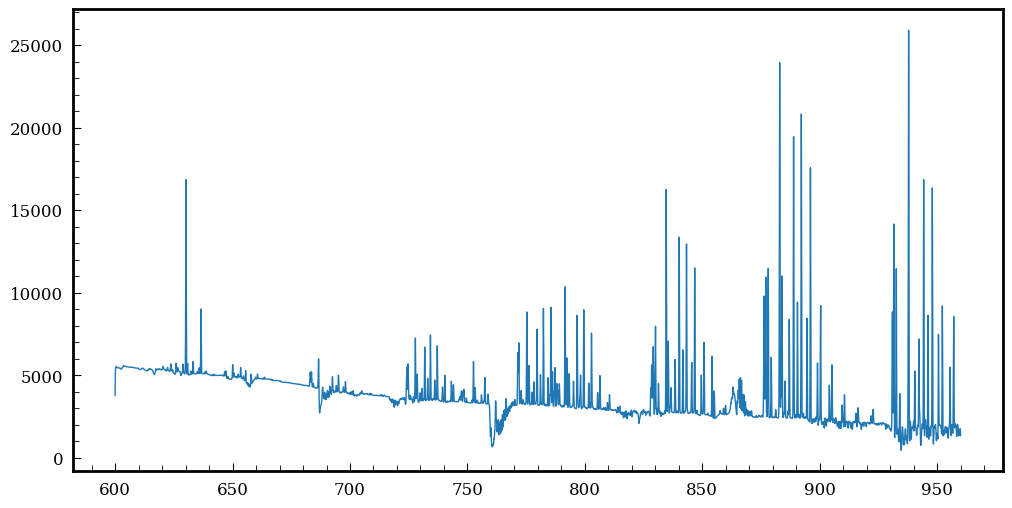

In [6]:
plt.plot(tab['lam'],tab['flux']);

- After all the sky configurations (moon + airmass) you load the atmosferic transmission, in `get_data` as:
        
        filename = f'{name}_{chan}_noatm.fits
        trans=Table.read(os.path.join(refdir,filename), unit_parse_strict="silent")


Lastly also the instrument transmissions are saved from the `{ins}_{chan}_noatm.fits`, after checking that the values of the table from the fits are inside the edges defined by `lbda1` and `lbda2` from the original dictionary

This is done with:

    ins['instrans'] = Spectrum(data=np.interp(ins['sky'][0]['emi'].wave.coord(),trans['WAVE']*10,trans['TOT']), wave=ins['sky'][0]['emi'].wave)
    
Where we save in the dictionary the `instrans` key as a MPDAF spectrum object starting from the transmission in the fits file computed at the wavelength of the emission of the first sky configuration we take into account 


###############

A bit redundant: doesn't really matter since the wavelengths of all the sky configurations for a specific instrument&channel are the same, we should have a single `lam` in a common tab I guess

###############


#### Here below you can se what's inside the WST object selecting instrument&channel

In [7]:
#change instrument and channel to see all the dictionaries, you will see that the Spectrum from in 'emi'
#are lacking the unit

obj_WST.ifs['red']

{'desc': 'Inspired from MUSE throughput',
 'version': '0.1 10/02/2023',
 'type': 'IFS',
 'obscuration': 0.18,
 'iq_fwhm': 0.1,
 'iq_beta': 2.5,
 'spaxel_size': 0.25,
 'dlbda': 0.97,
 'lbda1': 6000,
 'lbda2': 9600,
 'lsfpix': 2.5,
 'ron': 3.0,
 'dcurrent': 3.0,
 'wave': WCS Keywords
 
 Number of WCS axes: 1
 CTYPE : 'LINEAR'  
 CRVAL : 6000.0  
 CRPIX : 1.0  
 PC1_1  : 1.0  
 CDELT : 0.97  
 NAXIS : 0  0,
 'sky': [{'moon': 'brightsky',
   'airmass': 1.0,
   'emi': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
   'abs': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
   'filename': '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc/data/WST/ifs_red_brightsky_1.0.fits'},
  {'moon': 'brightsky',
   'airmass': 1.2,
   'emi': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
   'abs': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
   'filename': '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc/data/WST/ifs_red_brightsky_1.2.fits'},
  {'moon': 'bri

There are a few more instrumental parameter which can be computed through handy functions, one is the spectral resolution with `get_spectral_resolution()`:

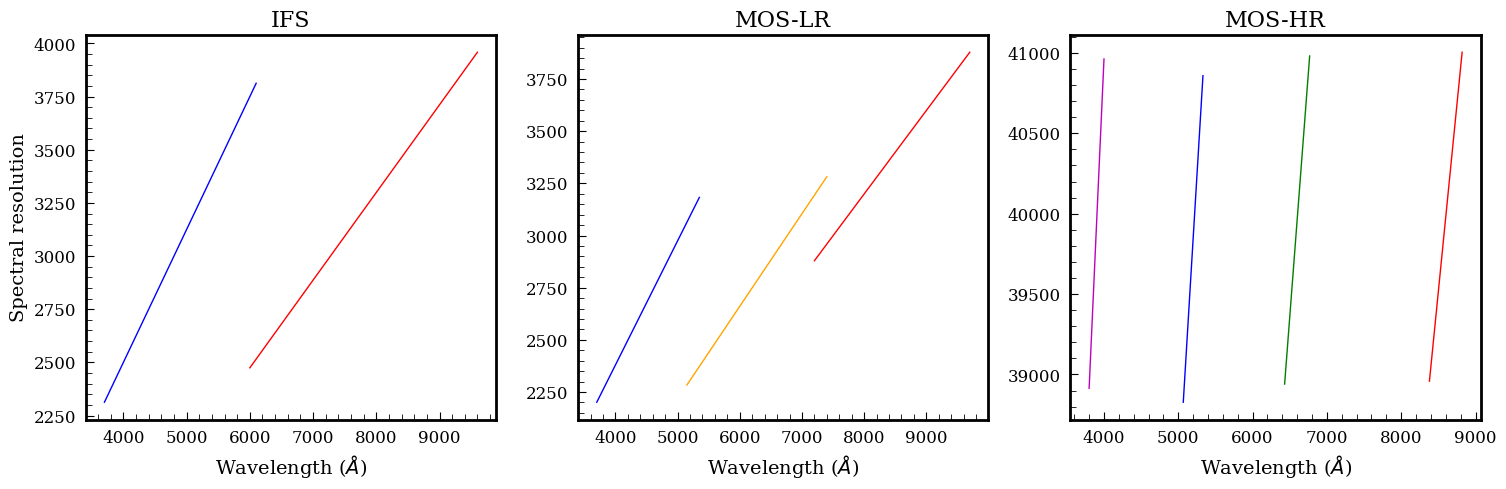

In [8]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(obj_WST.ifs['blue']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.ifs['blue']), color='b')
ax[0].plot(obj_WST.ifs['red']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.ifs['red']), color='r')
ax[1].plot(obj_WST.moslr['blue']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moslr['blue']), color='b')
ax[1].plot(obj_WST.moslr['orange']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moslr['orange']), color='orange')
ax[1].plot(obj_WST.moslr['red']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moslr['red']), color='r')
ax[2].plot(obj_WST.moshr['U']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moshr['U']), color='m')
ax[2].plot(obj_WST.moshr['B']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moshr['B']), color='b')
ax[2].plot(obj_WST.moshr['V']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moshr['V']), color='g')
ax[2].plot(obj_WST.moshr['I']['wave'].coord(), obj_WST.get_spectral_resolution(obj_WST.moshr['I']), color='r')


ax[0].set_xlabel('Wavelength ($\AA$)')
ax[1].set_xlabel('Wavelength ($\AA$)')
ax[2].set_xlabel('Wavelength ($\AA$)')
ax[0].set_ylabel('Spectral resolution')
ax[0].set_title('IFS')
ax[1].set_title('MOS-LR')
ax[2].set_title('MOS-HR');

Below you see plots for the transmission of telescope + instrument (which are stored in the `instrans` keyword),  
basically the ratio between light entering the system and reaching the detector:

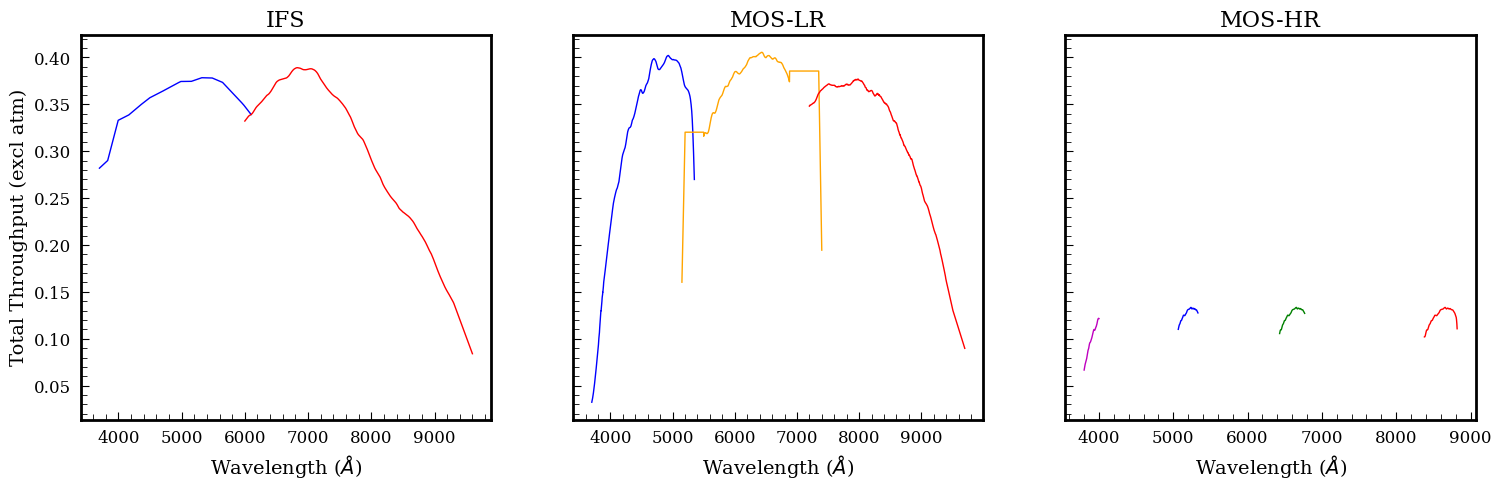

In [9]:
fig,ax = plt.subplots(1,3,figsize=(18,5), sharey=True)
ax[0].plot(obj_WST.ifs['blue']['instrans'].wave.coord(), obj_WST.ifs['blue']['instrans'].data, color='b')
ax[0].plot(obj_WST.ifs['red']['instrans'].wave.coord(), obj_WST.ifs['red']['instrans'].data, color='r')
ax[1].plot(obj_WST.moslr['blue']['instrans'].wave.coord(), obj_WST.moslr['blue']['instrans'].data, color='b')
ax[1].plot(obj_WST.moslr['orange']['instrans'].wave.coord(),obj_WST.moslr['orange']['instrans'].data, color='orange')
ax[1].plot(obj_WST.moslr['red']['instrans'].wave.coord(),obj_WST.moslr['red']['instrans'].data, color='r')

colo = ['m', 'b', 'g', 'r']
for i, chan in enumerate(obj_WST.moshr['channels']):
    ax[2].plot(obj_WST.moshr[chan]['instrans'].wave.coord(),obj_WST.moshr[chan]['instrans'].data, color = colo[i])
ax[0].set_xlabel(r'Wavelength ($\AA$)')
ax[1].set_xlabel(r'Wavelength ($\AA$)')
ax[2].set_xlabel(r'Wavelength ($\AA$)')
ax[0].set_ylabel('Total Throughput (excl atm)')
ax[0].set_title('IFS')
ax[1].set_title('MOS-LR')
ax[2].set_title('MOS-HR');

## OBSERVATION DATA STRUCTURE & SNR

The observations are stored as dictionaries, with keys that depend on the type of source being considered

The core object is a spectrum, defined also as a dictionary. We'll see all the type of sources, the easiest one is the **surface brightness** which means that is only defined by a spectrum, since it has not a spacial dependence (so in principle there should be no difference between _IFS_ and _MOS_ I guess)

## **surface brightness**:   
source which is entirely described by a spectrum, stored in `dspec`, this can be a:  
(1) `flatcont`  
(2) `line`  
(3) `template` (from the **Spextrum** package)  

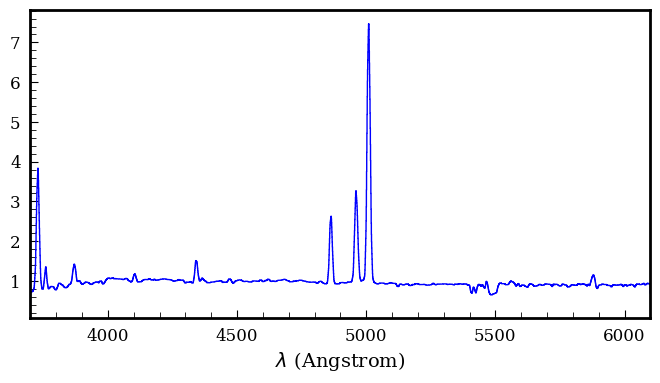

In [72]:
#try for a specific configuration, you can change this 
CONF = obj_WST.ifs['blue']
c = 'b'
wave = 4500 #should be in Angstrom
dw_flat = 100
dw = 50

#Leave un-commented only the type of spectrum you want to see

#dspec = dict(type='flatcont', wave=[wave-dw_flat,wave+dw_flat])

#dspec = dict(type='line', lbda=wave, sigma=10, skew=0) #lbda is the central wavelenght

dspec = dict(type='template', name='kc96/starb1', redshift=0., wave_center=wave, wave_width=dw) #here wave and 
#wave_width are just the wavelenght and range to use for normalizing the spectrum and they have to be both
#of them inside the template range

#the method get_spec() 
spec = obj_WST.get_spec(CONF, dspec, oversamp=10, lsfconv=True) #the lsf is stored in the WST object describes 
#how a point source is spread out by the instrument's optics and detector

_, ax = plt.subplots(figsize=(8, 4))

spec.plot(ax=ax, color = c)

###############  
**(all)**  
We note that there is redundancy in the call of the wavelength step and others, since in `get_spec` this is compute both as `dlbda = ins['dlbda']` and `lstep = ins['instrans'].get_step()`, with the former using the original key stored for the configuration `ins`, while the second is using the built-in method of the `mpdaf.Spectrum object`  

**(2)**  
We note that there is no dependence on the `CONF` we choose, as in the case of `flatcont`, which means that even for instance selecting `CONF = obj_WST.ifs['red']` or every other configuration there won't be a check for the line to be inside the configuration wavelength range, it is plotted anyway  
###############

------
Once the spectrum is defined for this kind of source the other parameters are set through `set_obs(obs)` method where `obs` is once again a dictionary which can contain:  

- moon: string (`darksky`, `greysky` or `brightsky`)
- airmass: float, for now should match one of the pre-comuted configuration
- ndit and dit: number of exposure and time (in s) of every exp
- ima_type: string (`sb` for the surface brightness, we'll see after the case of point/extended) -> CHANGE OBJ TIPE
- ima_area: the size of the area to be considered for S/N computation. It is needed only for IFS, for the MOS it is defined by the fiber aperture (I guess in arcsec^2)  
###############  
- spec_type: string, can be `continuum` or `line` (not clear how it links with `flatcont`/`line`/`template` of the `dspec`, according to documentation when **templates** are passed with dspec this should be set to `continuum`    
###############  

Another parameter is always added:
- totexp: total exposures in hours (`obs['ndit']*obs['dit']/3600.0`)

Specifically for the `line` spectral type we got more parameters to set:
- spec_range_type: string (`fixed` or `adaptive`)  
  in the first case the `spec_range_hsize_spectels` is used for a window large as `2 * spec_range_hsize_spectels + 1`  
  in the second case the the window is instead computed based on the FWHM of the line through `spec_range_kfwhm`


The last important parameter is:  
###############  
flux: in erg s-1 cm-2 arcsec-2 (I guess in the case of `sb`)
Is there an error in the documentation? Should be in **erg s-1 cm-2 arcsec-2 AA-1**?
############### 

---
Let's set up an observation for this simple case of `sb` source we saw and the flux:

In [73]:
obs = dict(
    moon='darksky',
    airmass = 1.0,
    ndit = 2,
    dit = 1800,
    spec_type = 'cont',
    ima_type = 'sb',
    ima_area = 1.0
)

obj_WST.set_obs(obs)

flux = 5.e-19 #not clear the unit as above

Now, given the spectrum defined above (`spec`, in this case let's use the `template`/`flatcont` since we set `spec_type = 'cont'`) we can compute with the main method `snr_from_source` the SNR along with all the `res` products (as below), for our instrument+channel configuration `CONF`  
Since we are considering the `sb` case (but even for the point source `ps` as we'll see) no `ima` parameter is needed

In [74]:
res = obj_WST.snr_from_source(CONF, flux, ima=None, spec=spec)

[DEBUG] Source type sb & cont Flux 5.00e-19 S/N 1.9 FracFlux 1.000 Nspaxels 16 Nspectels 1


Let's see what the code is doing step by step:

- with `_checkobs` we copy the relevant keywords in `obs` that will be used
- if `obs['spec_type']` is `cont` the flux is converted in /spectel from the Angstroem/spectel values stored in the instrument configuration

So assumed now that the fluxes are actually flux densities we have: the flux density per unit spectel instead of AA, then:

- The flux density is converted in flux density per unit volume pixel, I assume converting arcsec^2 with `tflux *= ins['spaxel_size']**2` and now we have the flux density per unit detector area (pxl x pxl) instead of arcsec^2


- `chekcobs` for the `ima_area` parameter, then with

         nspaxels = int(obs['ima_area']/ins['spaxel_size']**2 + 0.5)
         
  we compute the number of spacial pixels needed to cover the `ima_area` requested (and the length of one side assumed square, we save also the `ima_area` in arcsec^2 for the IFS  
  
###############   
For the MOS this is done taking (again for excess) the number of spaxels needed to cover **2** times (why?) the area of the fiber size which is given in arcsec  

Another thing not completely clear to me is the fact that we compute frac_flux which is 1 since frac_ima and frac_spec are both 1 here, so I do not understand completely the reason behind this  
############### 


- The last point is in fact to compute the `snr_from_spec` which is done without frac_flux but with 
             
      spec_data = tflux * tspec
      
  So i suppose that that flux is the normalization of where you flux value is one, let's say that you have to normalize the continuum in the case of templates, for the flat is always one the value so its basically multiplication regardless the wavelength

##### So we see now how `snr_from_spec` works:

this below is what we are passing as a spec to snr_from_spec, you can print it below if needed

In [75]:
spec2 = spec*flux 

then we retrieve (given our configuration and moon condition) the sky emission/absorption and inst transm cutting if needed in the range of wavelength of spec2

In [76]:
#convenient function to get the mpdaf spectra of emission/absorption of the sky
###############
#Here we note that it looks at the airmass configurations stored in the static files, looking for the most similar one
#However this should be changed when talking directly with the ESO SkyCalc to generate one
###############
sky_emi,sky_abs = obj_WST.get_sky(CONF, obs['moon']) 

#convenient function on the mpdaf to cut on the length of the spectrum given (useful in this case for flat, since
#the templates are already spanning the range of the CONF)
ins_sky = sky_emi.subspec(lmin=spec2.wave.get_start(), lmax=spec2.wave.get_end())
ins_ins = CONF['instrans'].subspec(lmin=spec2.wave.get_start(), lmax=spec2.wave.get_end())
ins_atm = sky_abs.subspec(lmin=spec2.wave.get_start(), lmax=spec2.wave.get_end())

Other data such as:
- the spaxel area
- the wavelength step
- the telescope effective area

###############  
Not completely clear why we have both diameter and area of the telescope, it's not simply diameter:  

    np.pi*(obj_WST.tel['diameter']/2)**2 > obj_WST.tel['area']  
###############  

then we compute the signal to noise:

In [77]:
w = spec2.wave.coord() #Angstrom
tel_eff_area = obj_WST.tel['area']*CONF['obscuration']

C_cgs = constants.c.cgs.value
H_cgs = constants.h.cgs.value
C_kms = constants.c.to(u.km/u.s).value

#wave converted in cm then lambda/HC is 1/erg * area (cm^2) * atmosferic transmission
a = (w*1.e-8/(H_cgs*C_cgs)) * (tel_eff_area*1.e4) * (ins_atm.data)
#then also * instrument/telescope transmission
Kt =  ins_ins * a

so this is **1/erg cm2** at every wavelength, will be multiplied for the flux we stored before to get the number of photons that reaches the detector

In [78]:
nph_source = spec2.copy()
#taking into account the time of the observation we get: 
nph_source.data = obs['dit'] * obs['ndit'] * Kt.data * spec2.data

which should be the number of photons per unit 1 spaxel x 1 spaxel (while the array is of course per unit spectel)

###############  
My main doubt here is - and this could be also a silly one 😃, related to the MOS:  

For the CCD where the fiber send the light, let's say the X direction is the lambda and the Y is the is the spacial dispersion, is the X direction also a spacial direction? In this case the computation of every quantity in terms of unit spaxel size x unit spaxel size is correct, if there is only one spacial direction, the Y in this example, then every conversion from arcsec^2 to instrument should be done as spaxel size x 1 pixel...

If the correct answer is the first case: if we have to consider in more than one X pixel the PSF in the MOS, then we are mixing different wavelength right?
###############  

Anyway, we then compute the noises, starting from the sky emission and all the rest:

In [79]:
dl = spec2.wave.get_step(unit='Angstrom')
#where the units of ins_sky (if you remember from tab.meta) are ph/s/m2/micron/arcsec2
nph_sky = ins_sky * ins_ins * obs['dit'] * obs['ndit'] * tel_eff_area * CONF['spaxel_size']**2 * (dl/1e4) 

#the other quantities
nb_voxels = 1 #since we are computing here the quantities for unit spectel and spaxels
ron_noise = np.sqrt(CONF['ron']**2*nb_voxels*obs['ndit'])
#because the dark current is given in hours we get
dark_noise = np.sqrt(CONF['dcurrent']*nb_voxels*obs['ndit']*obs['dit']/3600) 

###############  
I'm missing the conversion from photons to electron with **GAIN**, since the `ron` and `dark` are given in e- while we computed for the rest the photon numbers  
###############  

In [80]:
sky_noise = nph_sky.copy()
sky_noise.data = np.sqrt(nph_sky.data)
source_noise = spec2.copy()
source_noise.data = np.sqrt(nph_source.data)
tot_noise = spec2.copy()
tot_noise.data = np.sqrt(ron_noise**2 + dark_noise**2 + sky_noise.data**2 + source_noise.data**2)
snr = spec2.copy()

#final computation of the SNR per unit spaxels (as a function of spectel)
snr.data = nph_source.data / tot_noise.data

You can plot it below

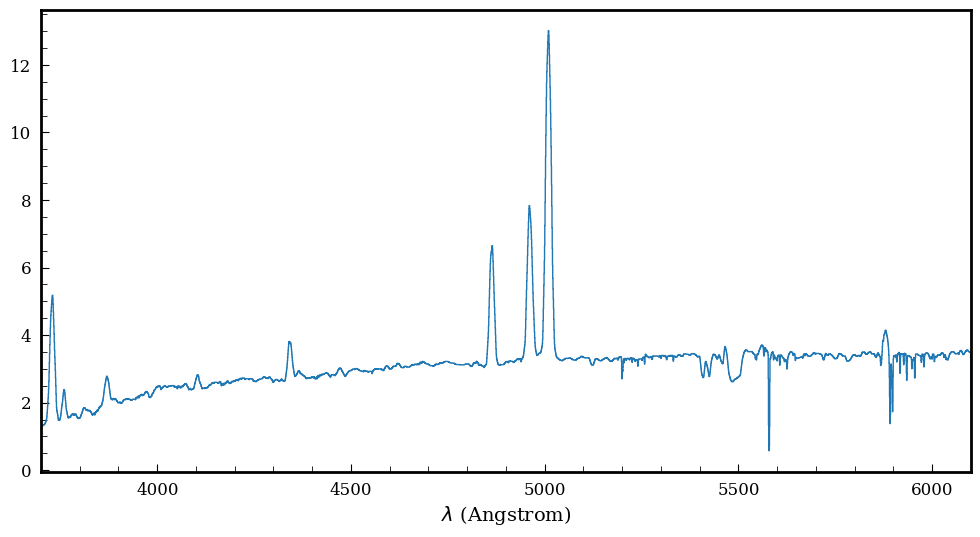

In [81]:
snr.plot()

The full results are returned as dictionaries, including:
- a subdictionary of all noises
- number of photons from source and sky
- SNR (in this case per unit voxel)
- all the inputs used (obs, CONF, ecc...)

Lastly, the SNR is computed additionaly also per unit area passed via `obs['ima_area']`, which is used for the IFS, while for the MOS this is by default set from the fiber `aperture` parameter from the used `CONF`.

It is then stored along with all other quantities (number of photons/noises/ecc...) in `res['spec']`

And you can see from the plot below how there is a slight difference in our example in the SNR, since this is integrated in an area of 1"x1" (`obs['ima_area']`) instead of 1 spaxel x 1 spaxel (0.25" x 0.25" in our `CONF`)

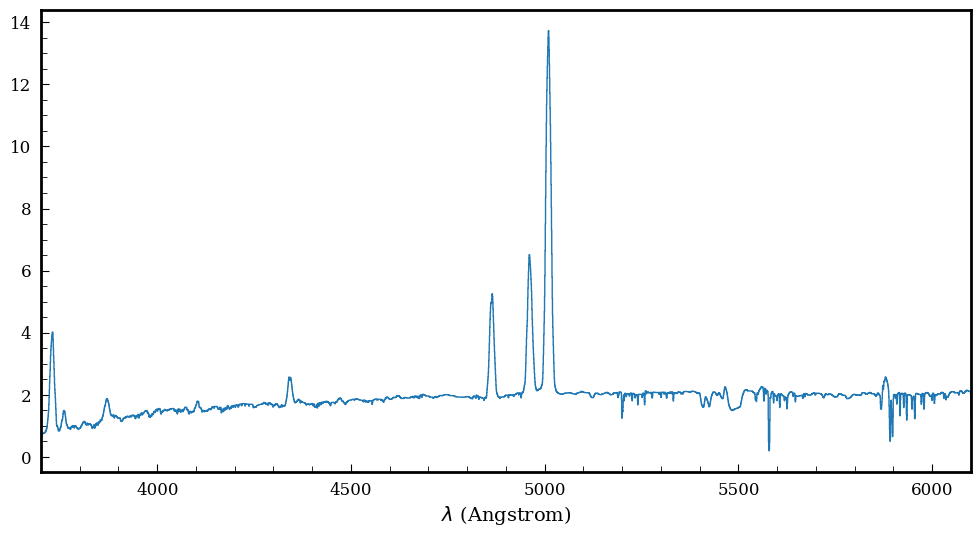

In [89]:
res['spec']['snr'].plot()